# 0. Initial Configuration

Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import gc

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    recall_score,
    f1_score,
    precision_score,
)

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

In [3]:
random.seed(42)
np.random.seed(42)

# 1. Dataset Preparation

## 1.1 Importing the dataset

In [ ]:
# importing the dataset into pandas dataframe

df_data_1 = pd.read_csv(
    "/content/drive/MyDrive/network_anomaly_detection/data/Monday-WorkingHours.pcap_ISCX.csv"
)
df_data_2 = pd.read_csv(
    "/content/drive/MyDrive/network_anomaly_detection/data/Tuesday-WorkingHours.pcap_ISCX.csv"
)
df_data_3 = pd.read_csv(
    "/content/drive/MyDrive/network_anomaly_detection/data/Wednesday-workingHours.pcap_ISCX.csv"
)
df_data_4 = pd.read_csv(
    "/content/drive/MyDrive/network_anomaly_detection/data/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
)
df_data_5 = pd.read_csv(
    "/content/drive/MyDrive/network_anomaly_detection/data/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
)
df_data_6 = pd.read_csv(
    "/content/drive/MyDrive/network_anomaly_detection/data/Friday-WorkingHours-Morning.pcap_ISCX.csv"
)
df_data_7 = pd.read_csv(
    "/content/drive/MyDrive/network_anomaly_detection/data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"
)
df_data_8 = pd.read_csv(
    "/content/drive/MyDrive/network_anomaly_detection/data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
)

In [ ]:
# combining the dataframes into a single dataframe

df_data = pd.concat(
    [
        df_data_1,
        df_data_2,
        df_data_3,
        df_data_4,
        df_data_5,
        df_data_6,
        df_data_7,
        df_data_8,
    ],
    ignore_index=True,
)

## 1.2 Data Preprocessing

In [ ]:
# Shape of dataset before cleaning
print("Before cleaning:", df_data.shape)

# === Convert inf/-inf to NaN ===
df_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# === Handle NULL values including those from inf replacements ===
null_values = df_data.isnull().sum()
print(f"{null_values.sum()} null values (including converted inf/-inf) found.\n")
if null_values.sum() > 0:
    print("Null values per column:\n", null_values[null_values > 0])
    df_data.dropna(inplace=True)

# === Handle duplicates ===
duplicate_values = df_data.duplicated().sum()
print(f"{duplicate_values} duplicate rows found.\n")
df_data.drop_duplicates(inplace=True)

# Reset index after cleaning
df_data.reset_index(drop=True, inplace=True)

# === Identify categorical columns (for encoding later) ===
categorical_col = df_data.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns:", categorical_col)

# Final dataset snapshot
print("\nDataset after cleaning:")
print(df_data.head())

# Shape of dataset after all cleaning steps
print("After cleaning:", df_data.shape)

Before cleaning: (2830743, 79)
5734 null values (including converted inf/-inf) found.

Null values per column:
 Flow Bytes/s       2867
 Flow Packets/s    2867
dtype: int64
307078 duplicate rows found.

Categorical columns: [' Label']

Dataset after cleaning:
    Destination Port   Flow Duration   Total Fwd Packets  \
0              49188               4                   2   
1              49188               1                   2   
2              49486               3                   2   
3              49486               1                   2   
4                 88             609                   7   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        0                           12   
2                        0                           12   
3                        0                           12   
4                        4                          484   

    Total Length of Bwd 

In [7]:
# Drop constant (single unique value) columns
constant_cols = [col for col in df_data.columns if df_data[col].nunique() == 1]

print(f"\nConstant columns (only 1 unique value): {constant_cols}")
print(f"Dropping {len(constant_cols)} constant column(s)...")

df_data.drop(columns=constant_cols, inplace=True)


Constant columns (only 1 unique value): [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
Dropping 8 constant column(s)...


In [ ]:
# cleaning columns
df_data.columns = df_data.columns.str.strip().str.lower().str.replace(" ", "_")
df_data.columns = df_data.columns.str.replace("[^A-Za-z0-9_]+", "", regex=True)

print("Cleaned column names:\n", df_data.columns.tolist())

Cleaned column names:
 ['destination_port', 'flow_duration', 'total_fwd_packets', 'total_backward_packets', 'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 'fwd_packet_length_max', 'fwd_packet_length_min', 'fwd_packet_length_mean', 'fwd_packet_length_std', 'bwd_packet_length_max', 'bwd_packet_length_min', 'bwd_packet_length_mean', 'bwd_packet_length_std', 'flow_bytess', 'flow_packetss', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'fwd_urg_flags', 'fwd_header_length', 'bwd_header_length', 'fwd_packetss', 'bwd_packetss', 'min_packet_length', 'max_packet_length', 'packet_length_mean', 'packet_length_std', 'packet_length_variance', 'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count', 'ack_flag_count', 'urg_flag_count', 'cwe_flag_count', 'ece_flag_count', 'downup_rati

In [ ]:
# View distribution of attack types
attack_counts = df_data["label"].value_counts()
attack_percent = df_data["label"].value_counts(normalize=True) * 100

print("\nAttack Type Distribution:")
print(pd.DataFrame({"Count": attack_counts, "Percentage": attack_percent.round(3)}))


Attack Type Distribution:
                              Count  Percentage
label                                          
BENIGN                      2095057      83.111
DoS Hulk                     172846       6.857
DDoS                         128014       5.078
PortScan                      90694       3.598
DoS GoldenEye                 10286       0.408
FTP-Patator                    5931       0.235
DoS slowloris                  5385       0.214
DoS Slowhttptest               5228       0.207
SSH-Patator                    3219       0.128
Bot                            1948       0.077
Web Attack � Brute Force       1470       0.058
Web Attack � XSS                652       0.026
Infiltration                     36       0.001
Web Attack � Sql Injection       21       0.001
Heartbleed                       11       0.000


In [ ]:
# Establishing both binary and multi-class labeling schemes for the dataset

# Assigning the input attributes to X for model training
x = df_data.copy()
x.drop("label", axis=1, inplace=True)

# Assigning the output labels to Y for model training
y = df_data["label"].copy()

# Binary labeling scheme
y_bin = y.map({"BENIGN": 0}).fillna(1).astype(int)

In [11]:
# Checking binary scheme
y_bin.value_counts()

,count
label,
0,2095057
1,425741


Freeing Up Memory

In [12]:
# Deleting individual DataFrames after merging to free RAM
del df_data_1, df_data_2, df_data_3, df_data_4
del df_data_5, df_data_6, df_data_7, df_data_8

gc.collect()

0

Data Visualisation

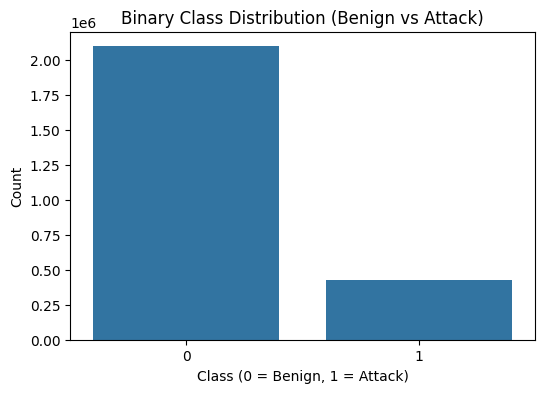



Class Imbalance under binary configuration:

Class 0 ratio: 83.11%
Class 1 ratio: 16.89%


In [ ]:
# Binary class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_bin)
plt.title("Binary Class Distribution (Benign vs Attack)")
plt.xlabel("Class (0 = Benign, 1 = Attack)")
plt.ylabel("Count")
plt.show()

print("\n")

# Computing metrics
class_ratios = y_bin.value_counts() / len(y_bin)
print("Class Imbalance under binary configuration:\n")
print(f"Class 0 ratio: {class_ratios[0]*100:.2f}%")
print(f"Class 1 ratio: {class_ratios[1]*100:.2f}%")

The dataset is highly imbalanced — 83.11% of samples belong to the BENIGN class.
This means a naive model that always predicts "BENIGN" would achieve 83.11% accuracy, without detecting any attacks.
Therefore, any meaningful model must beat this baseline and focus on detecting minority (attack) classes effectively.

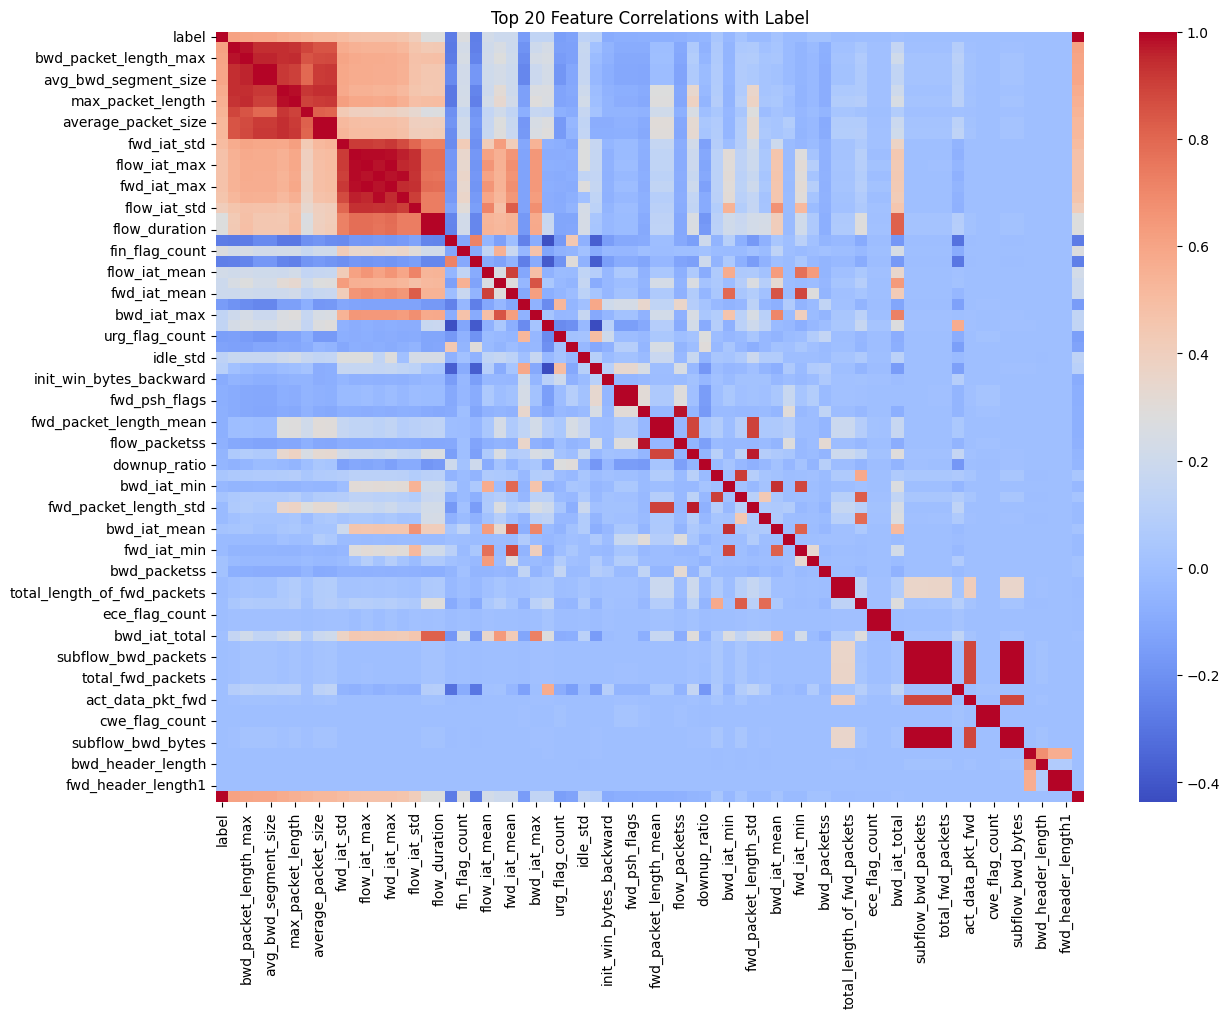

In [ ]:
# Correlation with the label (numeric version of label)
df_corr = x.copy()
df_corr["label"] = y_bin  # or y_mul for multiclass

# Compute correlations
corr = df_corr.corr().abs()
top_corr = corr["label"].sort_values(ascending=False)

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    df_corr[top_corr.index.tolist() + ["label"]].corr(), annot=False, cmap="coolwarm"
)
plt.title("Top 20 Feature Correlations with Label")
plt.show()

In [15]:
# deleting df.corr to free memory space
del df_corr
gc.collect()

14184

## 1.3 Spliting the dataset

In [ ]:
# Defining function to split dataset into train, test and validation sets
def get_datasets(
    features,
    labels,
    train_ratio=0.75,
    val_ratio=0.1,
    test_ratio=0.15,
    seed=42,
    shuffle=True,
):

    assert (
        abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6
    ), "Ratios must sum to 1.0"

    # Initial split: extract the training portion
    X_train, X_remaining, y_train, y_remaining = train_test_split(
        features,
        labels,
        stratify=labels,
        test_size=(1 - train_ratio),
        random_state=seed,
        shuffle=shuffle,
    )

    # Second split: divide the remaining data into validation and test sets
    val_fraction = val_ratio / (val_ratio + test_ratio)

    X_val, X_test, y_val, y_test = train_test_split(
        X_remaining,
        y_remaining,
        stratify=y_remaining,
        test_size=(1 - val_fraction),
        random_state=seed,
        shuffle=shuffle,
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# Extracting sets with percentages: 75-10-15 (%) for both schemes

X_train_bin, X_val_bin, X_test_bin, y_train_bin, y_val_bin, y_test_bin = get_datasets(
    x, y_bin, 0.75, 0.10, 0.15
)

In [ ]:
# Verifying the training, validation, and test splits

# 1. Check the shape of each split
print(f"X_train shape: {X_train_bin.shape}")
print(f"X_val shape:   {X_val_bin.shape}")
print(f"X_test shape:  {X_test_bin.shape}")
print(f"y_train shape: {y_train_bin.shape}")
print(f"y_val shape:   {y_val_bin.shape}")
print(f"y_test shape:  {y_test_bin.shape}")

# 2. Check the actual split ratios
total = len(y_bin)
print(f"\nSplit ratios:")
print(f"Train: {len(y_train_bin)/total:.2%}")
print(f"Val:   {len(y_val_bin)/total:.2%}")
print(f"Test:  {len(y_test_bin)/total:.2%}")

# 3. Check class distribution in each split (to ensure stratified sampling worked)
print("\nClass distribution in Train:")
print(y_train_bin.value_counts(normalize=True))

print("\nClass distribution in Validation:")
print(y_val_bin.value_counts(normalize=True))

print("\nClass distribution in Test:")
print(y_test_bin.value_counts(normalize=True))

# 4. Sanity check to ensure no overlap between splits
assert (
    len(set(X_train_bin.index).intersection(X_val_bin.index)) == 0
), "Overlap between train and val"
assert (
    len(set(X_train_bin.index).intersection(X_test_bin.index)) == 0
), "Overlap between train and test"
assert (
    len(set(X_val_bin.index).intersection(X_test_bin.index)) == 0
), "Overlap between val and test"

print("\n All checks passed. Splits look good!")

X_train shape: (1890598, 70)
X_val shape:   (252080, 70)
X_test shape:  (378120, 70)
y_train shape: (1890598,)
y_val shape:   (252080,)
y_test shape:  (378120,)

Split ratios:
Train: 75.00%
Val:   10.00%
Test:  15.00%

Class distribution in Train:
label
0    0.831108
1    0.168892
Name: proportion, dtype: float64

Class distribution in Validation:
label
0    0.831109
1    0.168891
Name: proportion, dtype: float64

Class distribution in Test:
label
0    0.831109
1    0.168891
Name: proportion, dtype: float64

 All checks passed. Splits look good!


## 1.4 Feature selection with XGBoost

In [ ]:
# Create and train the model
xgb_model = XGBClassifier(random_state=42, eval_metric="logloss")
xgb_model.fit(X_train_bin, y_train_bin)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

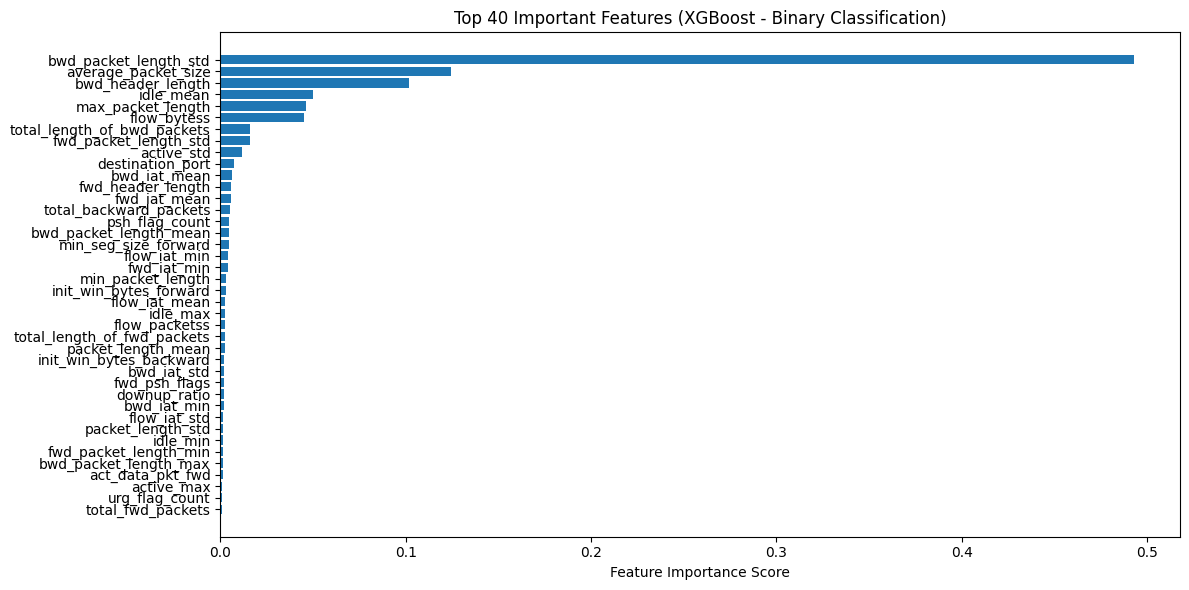

In [ ]:
# Extracting the feature importances from the trained model
importances = xgb_model.feature_importances_

# Pairing each feature name with its importance score
feature_importance = sorted(
    zip(X_train_bin.columns, importances), key=lambda x: x[1], reverse=True
)

# Spliting the pairs into separate lists for plotting
important_features = [feat for feat, score in feature_importance]
importance_scores = [score for feat, score in feature_importance]

# Plotting the top 40 most important features
plt.figure(figsize=(12, 6))
plt.barh(important_features[:40][::-1], importance_scores[:40][::-1])
plt.xlabel("Feature Importance Score")
plt.title("Top 40 Important Features (XGBoost - Binary Classification)")
plt.tight_layout()
plt.show()

Test Accuracy: 0.9992

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314259
           1       1.00      1.00      1.00     63861

    accuracy                           1.00    378120
   macro avg       1.00      1.00      1.00    378120
weighted avg       1.00      1.00      1.00    378120



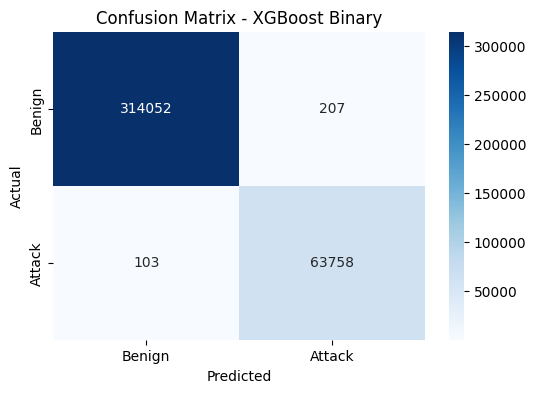

In [ ]:
# Make predictions on the test set
y_pred_bin = xgb_model.predict(X_test_bin)

# Accuracy
accuracy = accuracy_score(y_test_bin, y_pred_bin)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_bin, y_pred_bin))

# Confusion matrix
cm = confusion_matrix(y_test_bin, y_pred_bin)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Benign", "Attack"],
    yticklabels=["Benign", "Attack"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost Binary")
plt.show()

# 2.  Training XGBoost on the top 30 features

Test Accuracy: 0.9992

Classification Report - XGBoost (Top 30 Features):

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    314259
      Attack       1.00      1.00      1.00     63861

    accuracy                           1.00    378120
   macro avg       1.00      1.00      1.00    378120
weighted avg       1.00      1.00      1.00    378120



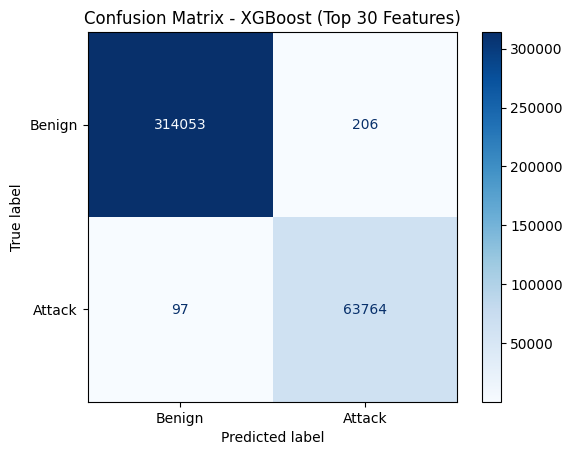

In [ ]:
# Create a DataFrame of features and their importance
feature_importance_df = pd.DataFrame(
    {"Feature": X_train_bin.columns, "Importance": xgb_model.feature_importances_}
).sort_values(by="Importance", ascending=False)

# Select top 30 most important features
top_30_features = feature_importance_df["Feature"].head(30).tolist()

# Subset the original binary splits to include only the top 30 features
X_train_top30 = X_train_bin[top_30_features]
X_val_top30 = X_val_bin[top_30_features]
X_test_top30 = X_test_bin[top_30_features]

# Retrain XGBoost on the reduced feature set
xgb_top30 = XGBClassifier(random_state=42, eval_metric="logloss")
xgb_top30.fit(X_train_top30, y_train_bin)

# Predict on the test set
y_pred_top30 = xgb_top30.predict(X_test_top30)

# Accuracy
accuracy = accuracy_score(y_test_bin, y_pred_bin)
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate and print classification report
print("\nClassification Report - XGBoost (Top 30 Features):\n")
print(
    classification_report(y_test_bin, y_pred_top30, target_names=["Benign", "Attack"])
)

# Display confusion matrix
cm = confusion_matrix(y_test_bin, y_pred_top30)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Attack"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost (Top 30 Features)")
plt.show()

> ### Feature Selection Evaluation Summary

To evaluate the impact of feature selection, we retrained XGBoost using only the **top 30 most important features** (ranked by feature importance from the full binary model).  
Compared to using all features or threshold-based selection, the top 30 approach provided:

- A **significant reduction in false negatives** (missed attacks)
- **No loss in accuracy or increase in false positives**
- A leaner and faster model, ideal for use in real-time systems

Hence, we finalized the **Top 30 features** for downstream models (Isolation Forest, Autoencoder, and ensemble) as they strike the best balance between **performance and efficiency**.


In [23]:
"""# Updated hyperparameter search space with default values in comments
param_dist = {
    'n_estimators': [100, 200, 300],               # default: 100
    'max_depth': [3, 5, 6, 7, 9],                     # default: 6
    'learning_rate': [0.01, 0.1, 0.2, 0.3],             # default: 0.3 (aka eta)
    'subsample': [0.6, 0.8, 1.0],                  # default: 1
    'colsample_bytree': [0.6, 0.8, 1.0],           # default: 1
    'gamma': [0, 0.1, 0.3, 1, 5],                  # default: 0
    'min_child_weight': [1, 3, 5],                 # default: 1
    'reg_lambda': [0, 1, 5],                       # default: 1 (L2 regularization)
    'reg_alpha': [0, 1, 5],                        # default: 0 (L1 regularization)
    'early_stopping_rounds': [10, 20, 30]          # for training control
}

# StratifiedKFold ensures balanced class distribution in splits
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize XGBClassifier with base settings and GPU usage
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    tree_method='gpu_hist',     # Enables GPU training in Colab
    predictor='gpu_predictor'   # Use GPU for prediction as well
)

# Setup randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=25,
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Train with early stopping (passed through param_dist)
random_search.fit(
    X_train_top30, y_train_bin,
    eval_set=[(X_val_top30, y_val_bin)],
    verbose=False
)

# Best estimator and parameters
best_model = random_search.best_estimator_
print("Best Parameters:\n", random_search.best_params_)"""

'# Updated hyperparameter search space with default values in comments\nparam_dist = {\n    \'n_estimators\': [100, 200, 300],               # default: 100\n    \'max_depth\': [3, 5, 6, 7, 9],                     # default: 6\n    \'learning_rate\': [0.01, 0.1, 0.2, 0.3],             # default: 0.3 (aka eta)\n    \'subsample\': [0.6, 0.8, 1.0],                  # default: 1\n    \'colsample_bytree\': [0.6, 0.8, 1.0],           # default: 1\n    \'gamma\': [0, 0.1, 0.3, 1, 5],                  # default: 0\n    \'min_child_weight\': [1, 3, 5],                 # default: 1\n    \'reg_lambda\': [0, 1, 5],                       # default: 1 (L2 regularization)\n    \'reg_alpha\': [0, 1, 5],                        # default: 0 (L1 regularization)\n    \'early_stopping_rounds\': [10, 20, 30]          # for training control\n}\n\n# StratifiedKFold ensures balanced class distribution in splits\ncv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)\n\n# Initialize XGBClassifier with b

### Hyperparameter Tuning with RandomizedSearchCV

To optimize the performance of the XGBoost classifier, `RandomizedSearchCV` was applied using stratified 3-fold cross-validation. A separate validation set was used during training to enable early stopping and prevent overfitting. The search process explored combinations from a predefined hyperparameter space and selected the configuration that resulted in the best performance.

**Best Parameters Found:**  
- `learning_rate`: 0.3  
- `max_depth`: 9  
- `min_child_weight`: 5  
- `gamma`: 0  
- `subsample`: 0.6  
- `colsample_bytree`: 0.8  
- `n_estimators`: 200  
- `reg_alpha`: 5  
- `reg_lambda`: 0  
- `early_stopping_rounds`: 30  

These tuned parameters were used to retrain the model, leading to improved classification performance compared to the untuned baseline. Early stopping ensured that the training process halted once performance on the validation set plateaued.

*Note: The search was executed using GPU acceleration in Colab. Warnings related to deprecated parameters (e.g., `gpu_hist`, `use_label_encoder`) were addressed according to the requirements of XGBoost v2.0+. The tuning process was computationally intensive but effective in enhancing overall model performance.*


Classification Report (Tuned XGBoost - Default Threshold 0.5):

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    314259
      Attack       1.00      1.00      1.00     63861

    accuracy                           1.00    378120
   macro avg       1.00      1.00      1.00    378120
weighted avg       1.00      1.00      1.00    378120



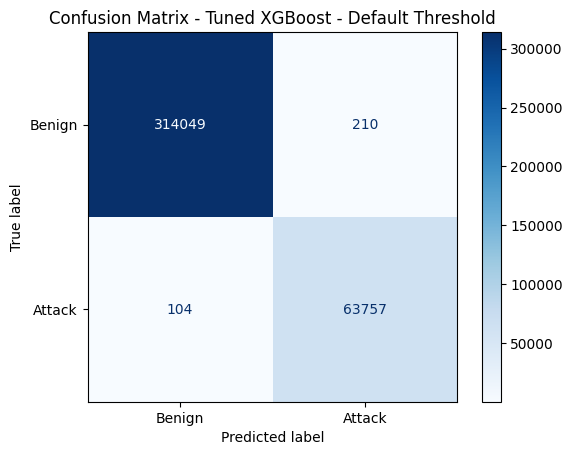

In [ ]:
# Initialize XGBClassifier with tuned parameters
xgb_tuned = XGBClassifier(
    learning_rate=0.3,
    max_depth=9,
    min_child_weight=5,
    gamma=0,
    subsample=0.6,
    colsample_bytree=0.8,
    n_estimators=200,
    reg_lambda=0,
    reg_alpha=5,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    verbosity=1,
)

# Train the model
xgb_tuned.fit(X_train_top30, y_train_bin)

# Predict using default threshold (0.5)
y_pred_tuned = xgb_tuned.predict(X_test_top30)

# Evaluate performance
print("Classification Report (Tuned XGBoost - Default Threshold 0.5):\n")
print(
    classification_report(y_test_bin, y_pred_tuned, target_names=["Benign", "Attack"])
)

# Confusion Matrix
cm_manual = confusion_matrix(y_test_bin, y_pred_tuned)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_manual, display_labels=["Benign", "Attack"]
)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Tuned XGBoost - Default Threshold")
plt.show()

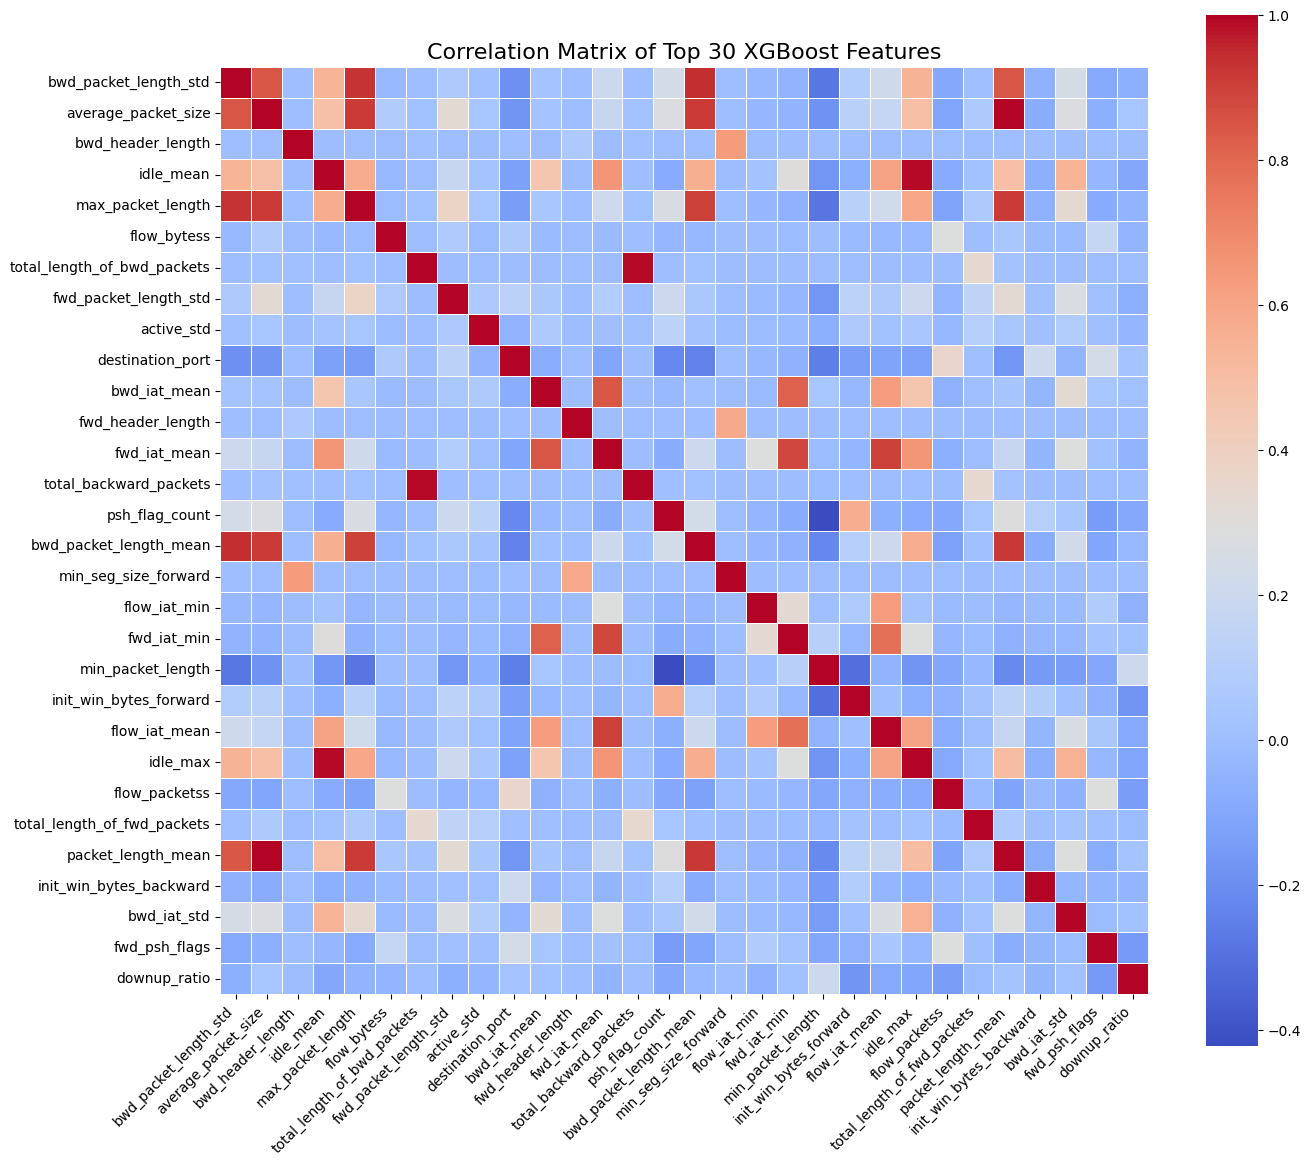

In [ ]:
# Compute the correlation matrix
corr_matrix = X_train_top30.corr()

# Set the plot size
plt.figure(figsize=(14, 12))

# Create a heatmap
sns.heatmap(
    corr_matrix,
    annot=False,  # Change to True if you want exact values
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    square=True,
)

plt.title("Correlation Matrix of Top 30 XGBoost Features", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [26]:
# deleting df.corr to free memory space
del corr_matrix
gc.collect()

22941

### XGBoost Classifier Summary

The XGBoost classifier was trained using the top 30 most relevant features identified from the binary classification phase. Hyperparameter tuning was performed using `RandomizedSearchCV`, which significantly improved the model’s performance by identifying the most optimal combination of parameters. To further enhance detection accuracy, especially for attack traffic, a custom decision threshold was selected based on the precision-recall curve to minimize false negatives.

In [27]:
# Initialize SMOTE with desired sampling strategy
smote = SMOTE(sampling_strategy=0.5, random_state=42)

# Apply SMOTE to training features and labels
X_train_top30_smote, y_train_bin_smote = smote.fit_resample(X_train_top30, y_train_bin)

In [28]:
gc.collect()

0

# 3.  Training the Multi layered perceptron

In [ ]:
minmax_scaler = MinMaxScaler()
# Fit on training data and transform all sets
X_train_top30_smote_scaled = pd.DataFrame(
    minmax_scaler.fit_transform(X_train_top30_smote),
    columns=X_train_top30_smote.columns,
)
X_val_top30_scaled = pd.DataFrame(
    minmax_scaler.transform(X_val_top30), columns=X_val_top30.columns
)
X_test_top30_scaled = pd.DataFrame(
    minmax_scaler.transform(X_test_top30), columns=X_test_top30.columns
)

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.initializers import HeUniform, GlorotUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

"""# Define input shape based on number of features in X_train_top30_scaled_smote
input_shape = X_train_top30_smote_scaled.shape[1]

# Initialize the model
model = Sequential([
    Input(shape=(input_shape,)),

    # Input + 1st Hidden Layer (tanh + Glorot)
    Dense(256, activation='tanh', kernel_initializer=GlorotUniform()),

    # Deeper layers (selu + He)
    Dense(128, activation='selu', kernel_initializer=HeUniform()),
    Dense(64,  activation='selu', kernel_initializer=HeUniform()),
    Dense(32,  activation='selu', kernel_initializer=HeUniform()),
    Dense(16,  activation='selu', kernel_initializer=HeUniform()),
    Dense(8,   activation='selu', kernel_initializer=HeUniform()),
    Dense(4,   activation='selu', kernel_initializer=HeUniform()),
    Dense(2,   activation='selu', kernel_initializer=HeUniform()),

    # Output layer for binary classification
    Dense(1, activation='sigmoid', kernel_initializer=GlorotUniform())
])

model.summary()"""

"# Define input shape based on number of features in X_train_top30_scaled_smote\ninput_shape = X_train_top30_smote_scaled.shape[1]\n\n# Initialize the model\nmodel = Sequential([\n    Input(shape=(input_shape,)),\n\n    # Input + 1st Hidden Layer (tanh + Glorot)\n    Dense(256, activation='tanh', kernel_initializer=GlorotUniform()),\n\n    # Deeper layers (selu + He)\n    Dense(128, activation='selu', kernel_initializer=HeUniform()),\n    Dense(64,  activation='selu', kernel_initializer=HeUniform()),\n    Dense(32,  activation='selu', kernel_initializer=HeUniform()),\n    Dense(16,  activation='selu', kernel_initializer=HeUniform()),\n    Dense(8,   activation='selu', kernel_initializer=HeUniform()),\n    Dense(4,   activation='selu', kernel_initializer=HeUniform()),\n    Dense(2,   activation='selu', kernel_initializer=HeUniform()),\n\n    # Output layer for binary classification\n    Dense(1, activation='sigmoid', kernel_initializer=GlorotUniform())\n])\n\nmodel.summary()"

In [31]:
"""# Compile with Adam optimizer and binary crossentropy loss
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)"""

"# Compile with Adam optimizer and binary crossentropy loss\nmodel.compile(\n    optimizer=Adam(learning_rate=0.001),\n    loss='binary_crossentropy',\n    metrics=['accuracy']\n)"

In [32]:
"""model_name  = "model.weights.h5"

# Setup callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    min_lr = 1e-07,
    patience=4,
    verbose=0
)

checkpoint = ModelCheckpoint(
    model_name,
    monitor='val_accuracy',
    mode = 'max',
    save_best_only=True,
    verbose=0
)

callbacks = [early_stop, reduce_lr, checkpoint]"""

'model_name  = "model.weights.h5"\n\n# Setup callbacks\nearly_stop = EarlyStopping(\n    monitor=\'val_accuracy\',\n    patience=8,\n    restore_best_weights=True,\n    verbose=1\n)\n\nreduce_lr = ReduceLROnPlateau(\n    monitor=\'val_accuracy\',\n    factor=0.1,\n    min_lr = 1e-07,\n    patience=4,\n    verbose=0\n)\n\ncheckpoint = ModelCheckpoint(\n    model_name,\n    monitor=\'val_accuracy\',\n    mode = \'max\',\n    save_best_only=True,\n    verbose=0\n)\n\ncallbacks = [early_stop, reduce_lr, checkpoint]'

In [33]:
del df_data, x, y, y_bin, X_train_bin, X_val_bin, X_test_bin
gc.collect()

0

In [34]:
"""history = model.fit(
    X_train_top30_smote_scaled, y_train_bin_smote,
    epochs=250,
    batch_size=1024,
    validation_data=(X_val_top30_scaled, y_val_bin),
    callbacks=callbacks,
    shuffle = True
)"""

'history = model.fit(\n    X_train_top30_smote_scaled, y_train_bin_smote,\n    epochs=250,\n    batch_size=1024,\n    validation_data=(X_val_top30_scaled, y_val_bin),\n    callbacks=callbacks,\n    shuffle = True\n)'

In [35]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/mlp_intrusion_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [36]:
test_loss, test_accuracy = model.evaluate(X_test_top30_scaled, y_test_bin, verbose=1)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

11817/11817 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.9837 - loss: 0.0332
Test Accuracy: 0.9836
Test Loss: 0.0337


In [37]:
"""# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()"""

"# Plot accuracy\nplt.figure(figsize=(12, 4))\n\nplt.subplot(1, 2, 1)\nplt.plot(history.history['accuracy'], label='Train Acc')\nplt.plot(history.history['val_accuracy'], label='Val Acc')\nplt.title('Model Accuracy')\nplt.xlabel('Epoch')\nplt.ylabel('Accuracy')\nplt.legend()\n\n# Plot loss\nplt.subplot(1, 2, 2)\nplt.plot(history.history['loss'], label='Train Loss')\nplt.plot(history.history['val_loss'], label='Val Loss')\nplt.title('Model Loss')\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.legend()\n\nplt.tight_layout()\nplt.show()"

11817/11817 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    314259
           1       0.92      0.99      0.95     63861

    accuracy                           0.98    378120
   macro avg       0.96      0.99      0.97    378120
weighted avg       0.98      0.98      0.98    378120

Accuracy : 0.9836
Precision: 0.9167
Recall   : 0.9933
F1 Score : 0.9535


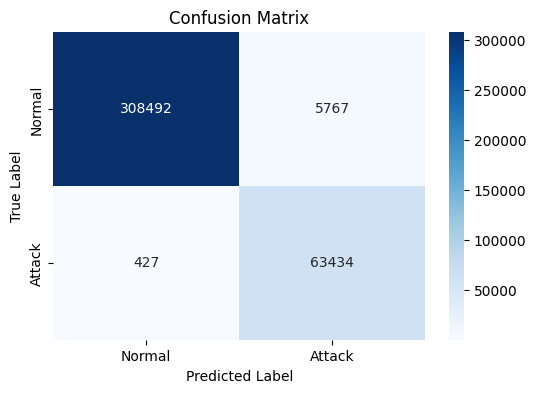

In [ ]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test_top30_scaled)
y_pred_bin = (y_pred_prob > 0.5).astype(int)

# Calculate evaluation metrics
acc = accuracy_score(y_test_bin, y_pred_bin)
prec = precision_score(y_test_bin, y_pred_bin)
rec = recall_score(y_test_bin, y_pred_bin)
f1 = f1_score(y_test_bin, y_pred_bin)

# Print classification report
print("Classification Report:\n")
print(classification_report(y_test_bin, y_pred_bin))

# Print individual scores
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_bin, y_pred_bin)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Attack"],
    yticklabels=["Normal", "Attack"],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [39]:
"""model_save_path = "/content/drive/MyDrive/mlp_intrusion_model.keras"

# Save the model
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")"""

'model_save_path = "/content/drive/MyDrive/mlp_intrusion_model.keras"\n\n# Save the model\nmodel.save(model_save_path)\nprint(f"Model saved to: {model_save_path}")'

# 4. Ensemble methods

In [ ]:
# Get predicted probabilities for validation set from XGBoost and MLP
xgb_val_preds = xgb_tuned.predict_proba(X_val_top30)[:, 1]
mlp_val_preds = model.predict(
    X_val_top30_scaled
).flatten()  # MLP output is already probability

7878/7878 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


In [45]:
# Stack predictions as features for meta-model
stacked_val_preds = np.column_stack((xgb_val_preds, mlp_val_preds))

In [46]:
from sklearn.naive_bayes import GaussianNB

# Initialize Gaussian Naive Bayes as the meta-classifier (meta_model)
meta_model = GaussianNB()

# Train the GNB meta-classifier on validation set predictions
meta_model.fit(stacked_val_preds, y_val_bin)

GaussianNB()

In [47]:
# Base model predictions on test set
xgb_test_preds = xgb_tuned.predict_proba(X_test_top30)[:, 1]
mlp_test_preds = model.predict(X_test_top30_scaled).flatten()

# Stack test set predictions for meta-model
stacked_test_preds = np.column_stack((xgb_test_preds, mlp_test_preds))

# Final prediction using meta-model
final_preds = meta_model.predict(stacked_test_preds)

11817/11817 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


Classification Report (Stacking Ensemble):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    314259
           1       1.00      1.00      1.00     63861

    accuracy                           1.00    378120
   macro avg       1.00      1.00      1.00    378120
weighted avg       1.00      1.00      1.00    378120



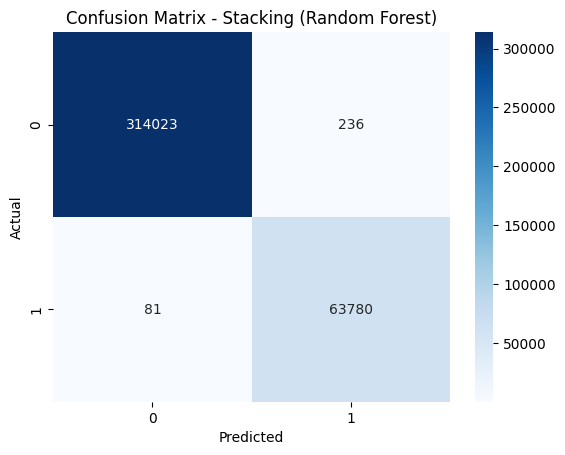

In [ ]:
# Evaluation metrics
print("Classification Report (Stacking Ensemble):")
print(classification_report(y_test_bin, final_preds))

# Confusion matrix
cm = confusion_matrix(y_test_bin, final_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Stacking (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [49]:
# Classification metrics
print("Accuracy :", accuracy_score(y_test_bin, final_preds))
print("Precision:", precision_score(y_test_bin, final_preds))
print("Recall   :", recall_score(y_test_bin, final_preds))
print("F1 Score :", f1_score(y_test_bin, final_preds))
print("\nClassification Report:\n", classification_report(y_test_bin, final_preds))

Accuracy : 0.9991616418068338
Precision: 0.9963134216445888
Recall   : 0.9987316202377038
F1 Score : 0.997521055389163

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    314259
           1       1.00      1.00      1.00     63861

    accuracy                           1.00    378120
   macro avg       1.00      1.00      1.00    378120
weighted avg       1.00      1.00      1.00    378120

